## Task 3

<ul><li> We throw independently balls into n bins until there are two balls in a single bin (a
conflict). Let B be the number of thrown balls.</li></ul>

In [1]:
import timeit
import numpy as np
import sympy as sp
import numba
from time import time
from matplotlib import pyplot as plt

In [2]:
def simulate_bins_and_balls_conflict_1(num_of_bins):
    occurences = set()
    upper_bound = num_of_bins + 1
    counter = 0
    while True:
        random_bin = np.random.randint(1, upper_bound)
        if random_bin in occurences:
            return counter
        else:
            occurences.add(random_bin)
            counter += 1

In [3]:
@numba.njit()
def simulate_bins_and_balls_conflict_2(num_of_bins):
    occurences = set()
    upper_bound = num_of_bins + 1
    counter = 0
    while True:
        random_bin = np.random.randint(1, upper_bound)
        if random_bin in occurences:
            return counter
        else:
            occurences.add(random_bin)
            counter += 1

Let's see example experiment results

In [4]:
number_of_bins = 100000

In [5]:
print(f'Function 1: {simulate_bins_and_balls_conflict_1(number_of_bins)}')
print(f'Function 2: {simulate_bins_and_balls_conflict_2(number_of_bins)}')

Function 1: 470
Function 2: 462


In [6]:
%%timeit
simulate_bins_and_balls_conflict_1(number_of_bins)

1.1 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
simulate_bins_and_balls_conflict_2(number_of_bins)

13.6 µs ± 77.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
def repeat_experiments_1(num_of_bins, num_of_trials):
    results = np.zeros(num_of_trials)
    for i in range(num_of_trials):
        results[i] = simulate_bins_and_balls_conflict_1(num_of_bins)
    return results

In [9]:
@numba.njit()
def repeat_experiments_2(num_of_bins, num_of_trials):
    results = np.zeros(num_of_trials)
    for i in range(num_of_trials):
        results[i] = simulate_bins_and_balls_conflict_2(num_of_bins)
    return results

In [10]:
@numba.njit(parallel=True)
def repeat_experiments_3(num_of_bins, num_of_trials):
    results = np.zeros(num_of_trials)
    for i in numba.prange(num_of_trials):
        results[i] = simulate_bins_and_balls_conflict_2(num_of_bins)
    return results

In [11]:
number_of_trials = 10000
number_of_bins = 1000

In [12]:
%%timeit
repeat_experiments_1(number_of_bins, number_of_trials)

1.12 s ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
repeat_experiments_2(number_of_bins, number_of_trials)

13.3 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
repeat_experiments_3(number_of_bins, number_of_trials)

1.77 ms ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
parameters = [10, 100, 1000]
histograms = []
times = []
number_of_trials = 1000000

for n in parameters:
    time1 = time()
    histograms.append(repeat_experiments_3(n, number_of_trials))
    time2 = time()
    times.append(round(time2 - time1, 5))
print(*times)

0.0405 0.075 0.1845


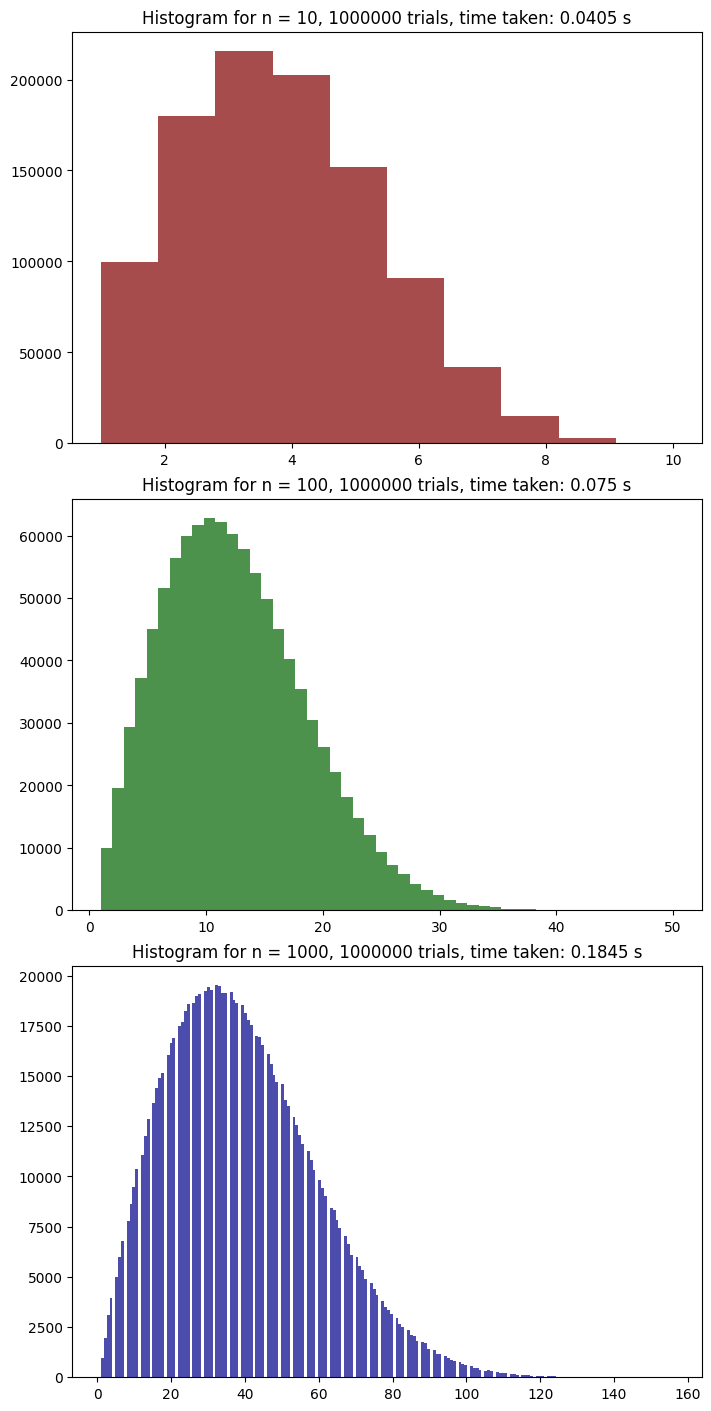

In [16]:
figure, axes = plt.subplots(3, 1, layout='constrained', figsize=(7,14))

bins = [10, 50, 200]
colors = ['maroon', 'darkgreen', 'darkblue']
for index, (result, num_bins, color, time_, bin_) in enumerate(zip(histograms, parameters, colors, times, bins)):
    axes[index].hist(result, bins=bin_, color=color, alpha=0.7, align='mid')
    title = f'Histogram for n = {num_bins}, {number_of_trials} trials, time taken: {time_} s'
    axes[index].set(title=title)

<ul><li>For n ∈ [10, 50000] find an approximation of E(B). Compare this with the theoretical results presented during the lecture.</li></ul>

In [17]:
bin_range = np.arange(10, 100, 10)

In [18]:
@numba.njit(parallel=True)
def expected_value(n_range, num_of_trials):
    expected_value = np.zeros(len(n_range))
    for i in numba.prange(len(n_range)):
        expected_value[i] = repeat_experiments_2(n_range[i], num_of_trials).mean()
    return expected_value

In [19]:
print(f'Expected value: {expected_value(bin_range, 10000)}')

Expected value: [ 3.6579  5.282   6.5484  7.6318  8.5133  9.4456 10.2006 10.7711 11.6161]


In [20]:
bin_range = np.arange(10, 5000, 100)

In [21]:
%%timeit
expected_value(bin_range, 1000)

19.7 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
bin_range = np.arange(10, 5000, 20)
trials = 100000

In [23]:
time1 = time()
expected_value_range = expected_value(bin_range, trials)
time2 = time()
time_passed = round(time2 - time1, 3)

In [24]:
n = sp.symbols('n', integer=True)  # Number of bins
k = sp.symbols('k', integer=True)  # Iterator for summation
j = sp.symbols('j', integer=True)

product_term = sp.Product((n - j) / n, (j, 1, k))
ex_value = 1 + sp.Sum(product_term, (k, 1, n - 1))

In [25]:
@numba.njit()
def expected_value_theoretical(n):
    total = 0
    for k in range(1, n):
        product = 1
        for j in range(1, k + 1):
            product *= (n - j) / n
        total += product
    return 1 + total

In [26]:
@numba.njit(parallel=True)
def expected_value_theoretical_range(n_range):
    ex_val_range = np.zeros(len(n_range))
    for i in numba.prange(len(n_range)):
        ex_val_range[i] = expected_value_theoretical(n_range[i])
    return ex_val_range

In [27]:
%%timeit
expected_value_theoretical(5000)

15.9 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit
expected_value_theoretical_range(bin_range)

381 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
expected_value_theoretical = expected_value_theoretical_range(bin_range)

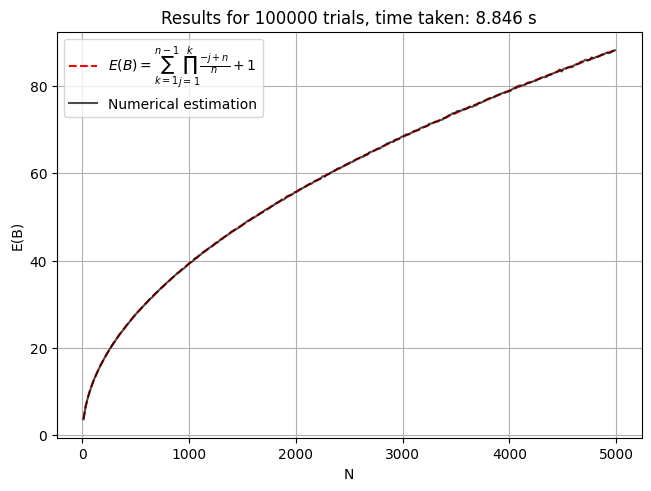

In [31]:
figure2, axes2 = plt.subplots(1, 1, layout='constrained')
axes2.set(xlabel='N', ylabel='E(B)')
axes2.set_title(f'Results for {trials} trials, time taken: {time_passed} s')
axes2.grid()
axes2.plot(bin_range, expected_value_theoretical, color='red', linestyle='--', label=f'$E(B)={sp.latex(ex_value)}$')
axes2.plot(bin_range, expected_value_range, color='black', label='Numerical estimation', alpha=0.7)
axes2.legend()